In [2]:
import numpy as np

import gym
import gym_minigrid

from oracle.oracle import Oracle, OracleWrapper
from oracle.generator import gen_phrases
from oracle.lang import parser, TreeToGrid

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
A = gen_phrases()

In [182]:
vocab = ["unseen ", "empty ", "wall ", "floor ", "door ",
         "key ", "box ", "goal ", "lava ", "agent ",
         "red ", "green ", "blue ", "purple ", "yellow ", 
         "grey ", "north ", "south ", "west ", "east ", 
         "is ", "is ", "is ", "is ", "is ", "is ", "is ",
         "open ", "closed ", "locked "]

noun = ["unseen ", "empty ", "wall ", "floor ", "door ", 
        "key ", "ball ", "box ", "goal ", "lava ", "agent "]
adjective = ["red ", "green ", "blue ", "purple ", "yellow ", "grey "]
verb = ["is "]
state = ["open ", "closed ", "locked "]
direction = ["north ", "south ", "west ", "east "]


def reward_modifier(question):
    words = question.split()
    space_words = []
    for item in words:
        space_words.append(item + str(" "))
    
    reward = -5
    if space_words[0] in adjective:
        reward += 1
    elif space_words[1] in noun:
        reward += 1
    elif space_words[2] in verb:
        reward += 2
    elif space_words[3] in state or space_words[3] in direction:
        reward += 1
    return reward

In [183]:
class SharedCNN(nn.Module):
    def __init__(self, action_dim=7, vocab_size=10):
        super(SharedCNN, self).__init__()
        
        self.vocab_size= vocab_size

        self.image_conv = nn.Sequential(
            nn.Conv2d(3, 16, (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU())

        self.policy_head = nn.Linear(194, action_dim)  # 194 is 128 of hx + 2 of answer + 64 obs CNN
        self.value_head = nn.Linear(194, 1)  # 194 is 128 of hx + 2 of answer + 64 obs CNN
        
        # CNN output is 64 dims
        # Assuming qa_history is also 64 dimensional
        self.question_rnn = nn.LSTMCell(self.vocab_size, 128) # (input_size, hidden_size)
        self.question_head = nn.Linear(128, vocab_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, answer, hx, qa_history, flag="policy"):
        # Shared Body
        x = x.view(-1, 3, 7, 7)  # x: (batch, C_in, H_in, W_in)
        batch = x.shape[0]
        x = self.image_conv(x).view(-1, 64)  # x: (batch, hidden)

        # Split heads
        if flag == "policy":
            x = torch.cat((x, answer, hx), 1)
            x_pol = self.policy_head(x)
            return x_pol
        elif flag == "value":
            x = torch.cat((x, answer, hx), 1)
            x_val = self.value_head(x)
            return x_val
        elif flag == "question":
            hx = torch.cat((x,qa_history.view(-1,64)),1)
            cx = torch.randn(hx.shape) # (batch, hidden_size)
            x = torch.rand((1, self.vocab_size))  # First input is noise
            output = []
            entropy_qa = 0
            log_probs_qa = []
            for count in range(5):                
                hx_tmp, cx_tmp = self.question_rnn(x, (hx, cx))
                dist = self.softmax(self.question_head(hx_tmp))
                m = distributions.Categorical(dist)
                tkn_idx = m.sample()
                log_probs_qa.append(m.log_prob(tkn_idx))
                entropy_qa += m.entropy().item()
                if count == 4: # We want the last hidden state to include the 4th word
                    break
                output.append(tkn_idx)
                x = torch.zeros((batch, self.vocab_size))
                x[:, tkn_idx] = 1

                hx = hx_tmp.data
                cx = cx_tmp.data

            output = torch.stack(output, dim=0)
            return output, hx_tmp, log_probs_qa, entropy_qa


In [187]:
class PPOAgent():
    def __init__(self, state_dim, action_dim, vocab, hidden_dim=64, learning_rate=0.001,
                 gamma=0.99, clip_param=0.2, value_param=1, entropy_param=0.01,
                 lmbda=0.95, backward_epochs=3):
        self.vocab = vocab
        self.vocab_size = len(vocab)
        
        self.hidden_dim = hidden_dim
        self.gamma = gamma
        self.lmbda = lmbda

        self.model = SharedCNN(vocab_size=self.vocab_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

        self.clip_param = clip_param
        self.entropy_param = entropy_param
        self.value_param = value_param
        self.T = 1

        self.done = True
        self.data = []
        self.backward_epochs = backward_epochs
        
    def ask(self, observation):
        # Will this be taking the history of questions?
        # And history of states?
        qa_history = torch.rand((1,64))
        observation = torch.FloatTensor(observation).to(device)
        tkn_idxs, hx, log_probs_qa, entropy_qa = self.model(observation, _, _, qa_history, flag="question")
        output = str()
        for word in tkn_idxs:
            output += str(self.vocab[word])
        return output, hx, log_probs_qa, entropy_qa

    def act(self, observation, ans, hx):
        # Calculate policy
        observation = torch.FloatTensor(observation).to(device)
        ans = torch.FloatTensor(ans).view((-1,2)).to(device)
        logits = self.model(observation, ans, hx, _, flag="policy")
        action_prob = F.softmax(logits.squeeze()/self.T, dim=-1)
        dist = distributions.Categorical(action_prob)
        action = dist.sample()
        probs = action_prob[action]  # Policy log prob 
        entropy = dist.entropy()  # Entropy regularizer
        return action.detach().item(), probs, entropy

    def update(self):
        obs, ans, hx, a, reward, next_obs, done, log_prob, entropy = self.get_batch()

        for i in range(self.backward_epochs):
            # Get current V
            V_pred = self.model(obs, ans, hx, _, flag="value").squeeze()
            # Get next V
            next_V_pred = self.model(next_obs, ans, hx, _, flag="value").squeeze()

            # Compute TD error
            target = reward.squeeze().to(device) + self.gamma * next_V_pred * done.squeeze().to(device)
            td_error = (target - V_pred).detach()

            # Generalised Advantage Estimation
            advantage_list = []
            advantage = 0.0
            for delta in reversed(td_error):
                advantage = self.gamma * self.lmbda * advantage + delta
                advantage_list.append([advantage])
            advantage_list.reverse()
            advantage = torch.FloatTensor(advantage_list).to(device)

            # Clipped PPO Policy Loss
            logits = self.model(obs, ans, hx, _, flag="policy")
            probs = F.softmax(logits, dim=-1)
            pi_a = probs.squeeze(1).gather(1, torch.LongTensor(a.long()).to(device))
            ratio = torch.exp(torch.log(pi_a) - torch.log(log_prob))
            surrogate1 = ratio * advantage
            surrogate2 = advantage * torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param)
            L_clip = torch.min(surrogate1, surrogate2).mean()

            # Entropy regularizer
            L_entropy = self.entropy_param * entropy.detach().mean()

            # Value function loss
            L_value = self.value_param * F.smooth_l1_loss(V_pred, target.detach())

            total_loss = -(L_clip - L_value + L_entropy).to(device)

            # Update params
            self.optimizer.zero_grad()
            total_loss.backward(retain_graph=True)
            self.optimizer.step()
        return total_loss.item()
    
    def update_QA(self, reward, log_prob, entropy):
        for i in range(1):
            # Reinforce Loss - TODO: check entropy parametr to avoid deterministic collapse
            total_loss = -(reward * torch.cat(log_prob).mean() 
                            + 0.05*entropy).to(device)
            # Update params
            self.optimizer.zero_grad()
            total_loss.backward(retain_graph=True)
            self.optimizer.step()
        return total_loss.item()

    def store(self, transition):
        self.data.append(transition)

    def get_batch(self):
        obs_batch = []
        ans_batch = []
        hx_batch = []
        a_batch = []
        r_batch = []
        next_obs_batch = []
        prob_batch = []
        entropy_batch = []
        done_batch = []
        for transition in self.data:
            obs, ans, hx, action, reward, next_obs, prob, entropy, done = transition
            
            obs_batch.append(obs)
            ans_batch.append(ans)
            hx_batch.append(hx)
            a_batch.append([action])
            r_batch.append([reward])
            next_obs_batch.append(next_obs)
            prob_batch.append([prob])
            entropy_batch.append([entropy])
            done_bool = 0 if done else 1
            done_batch.append([done_bool])
        
        obs = torch.FloatTensor(obs_batch).to(device)
        ans = torch.FloatTensor(ans_batch).to(device)
        hx = torch.cat(hx_batch)
        a = torch.FloatTensor(a_batch).to(device)
        r = torch.FloatTensor(r_batch).to(device)
        next_obs = torch.FloatTensor(next_obs_batch).to(device)
        prob = torch.FloatTensor(prob_batch).to(device)
        entropy = torch.FloatTensor(entropy_batch).to(device)
        done = torch.FloatTensor(done_batch).to(device)

        self.data = []

        return obs, ans, hx, a, r, next_obs, done, prob, entropy


In [188]:
def GAEtrain(env, agent, exploration=True, n_episodes=1000,
             log_interval=50, verbose=False, ID=False):
    episode = 0
    episode_loss = 0

    episode_reward = []
    loss_history = []
    reward_history = []

    state = env.reset()['image']  # Discard other info
    step = 0
    
    avg_syntax_r = 0

    while episode < n_episodes:
        # Ask - TODO pass qa_history
        question, hx, log_probs_qa, entropy_qa = agent.ask(state)
        
        # Answer 
        ans, q_reward = env.answer(question)
        q_reward += reward_modifier(question)/20
        avg_syntax_r += 1/log_interval * (q_reward - avg_syntax_r)
        
        if reward_modifier(question) == 0:
            print(question, ans)
        
        # Update Q&A - inner loop REINFORCE
        # TODO: check entropy parameter to avoid deterministic collapse
        agent.update_QA(q_reward, log_probs_qa, entropy_qa)

        # Act
        a, log_prob, entropy = agent.act(state, ans, hx)

        # Step
        next_state, r, done, _ = env.step(a)
        if r > 0:
            print("Goal reached")
            
        r += q_reward
        next_state = next_state['image']  # Discard other info
        # Store
        if exploration:
            agent.store((state, ans, hx, a, r, next_state,
                         log_prob.item(), entropy.item(), done))

        # Advance
        state = next_state
        step += 1

        # Logging
        episode_reward.append(r)

        if done:
            # Update
            if exploration:
                episode_loss = agent.update()

            state = env.reset()['image']  # Discard other info
            step = 0

            loss_history.append(episode_loss)
            reward_history.append(sum(episode_reward))
            episode_reward = []

            episode += 1

            if (episode) % log_interval == 0:
                if verbose:
                    avg_R = np.sum(reward_history[-log_interval:])/log_interval
                    print(f"Episode: {episode}, Reward: {avg_R:.2f}, Avg. syntax {avg_syntax_r:.2f}")

    return loss_history, reward_history


In [189]:
# Environment
env = gym.make("MiniGrid-MultiRoom-N6-v0")
env = OracleWrapper(env, syntax_error_reward=0)  # MiniGrid-MultiRoom-N2-S4-v0, MiniGrid-Empty-5x5-v0
env.seed(0)
state_dim = env.observation_space['image'].shape
action_dim = env.action_space.n

# Agent Params
hidden_dim = 32
lr = 0.0001
gamma = 0.99
lmbda = 0.95
clip = 0.2
entropy_param = 0.01
value_param = 1

N_eps = 1000
train_log_interval = 1

runs = 5

# Store data for each run
runs_reward = []

for i in range(runs):
    print(f"========================== TRAINING - RUN {i+1:.0f}/{runs:.0f} ==========================")
    # Agent
    agent = PPOAgent(state_dim, action_dim, vocab, hidden_dim, 
                        lr, gamma, clip, value_param, entropy_param)
        
    _, train_reward = GAEtrain(env, agent, exploration = True,
                               n_episodes = N_eps, log_interval = train_log_interval,
                                verbose = True)

    # store result for every run
    runs_reward.append(train_reward)

========================== TRAINING - RUN 1/5 ==========================
Episode: 1, Reward: -24.95, Avg. syntax -0.20
Episode: 2, Reward: -25.30, Avg. syntax -0.20
Episode: 3, Reward: -24.60, Avg. syntax -0.20
Episode: 4, Reward: -24.70, Avg. syntax -0.20
Episode: 5, Reward: -24.90, Avg. syntax -0.20
Episode: 6, Reward: -24.90, Avg. syntax -0.20
Episode: 7, Reward: -25.30, Avg. syntax -0.20
Episode: 8, Reward: -24.75, Avg. syntax -0.20
Episode: 9, Reward: -24.25, Avg. syntax -0.20
Episode: 10, Reward: -24.75, Avg. syntax -0.20
Episode: 11, Reward: -25.15, Avg. syntax -0.20
Episode: 12, Reward: -24.80, Avg. syntax -0.20
Episode: 13, Reward: -25.15, Avg. syntax -0.20
Episode: 14, Reward: -24.85, Avg. syntax -0.20
Episode: 15, Reward: -25.75, Avg. syntax -0.25
Episode: 16, Reward: -24.90, Avg. syntax -0.20
Episode: 17, Reward: -25.70, Avg. syntax -0.25
Episode: 18, Reward: -25.25, Avg. syntax -0.25
Episode: 19, Reward: -25.45, Avg. syntax -0.20
Episode: 20, Reward: -25.10, Avg. syntax -0

KeyboardInterrupt: 

In [150]:
state = env.reset()
state = torch.FloatTensor(state['image'])
agent.ask(state)

('blue key is open ',
 tensor([[-1.4987e-01, -8.8070e-02,  2.3550e-01, -3.5164e-01,  2.2259e-01,
           5.3818e-02,  5.2285e-02,  1.7358e-01,  7.0281e-02,  6.2544e-02,
          -1.7478e-02, -4.2853e-01,  4.5483e-02,  8.7847e-02, -5.1673e-01,
           3.3934e-01,  6.0116e-01, -1.1967e-01, -3.6384e-01,  4.0244e-02,
           1.6689e-01,  2.2117e-01, -3.3755e-01,  4.4267e-02,  3.0182e-01,
           5.2772e-02, -6.2667e-02, -5.3106e-02,  7.2970e-01, -1.5856e-01,
           2.6562e-01, -4.9788e-02, -3.0367e-02, -2.5355e-01, -2.9403e-01,
           3.9770e-02, -6.0985e-01,  8.4193e-02,  2.6868e-01, -3.1644e-01,
           4.4740e-02,  4.0602e-01, -4.7703e-02,  2.8711e-01,  2.0325e-01,
          -9.0673e-02,  5.4958e-04, -1.9873e-01,  6.8613e-02, -9.1061e-04,
           1.8746e-01,  1.3479e-01, -2.2023e-01, -4.3884e-03, -3.8876e-01,
           1.2140e-01,  1.5330e-01,  1.8720e-03,  5.0013e-01, -4.1129e-01,
          -1.2118e-01, -3.7203e-01,  7.7773e-01, -5.2934e-01, -6.7255e-01,
   

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
# Helper
def show_state(env, step=0):
    plt.figure(3, figsize=(10, 10))
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    # pause for plots to update
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.pause(0.0001) 

In [6]:
# Environment
env = OracleWrapper(gym.make("MiniGrid-Empty-8x8-v0"))  
env.seed(0)
state_dim = env.observation_space['image'].shape
action_dim = env.action_space.n


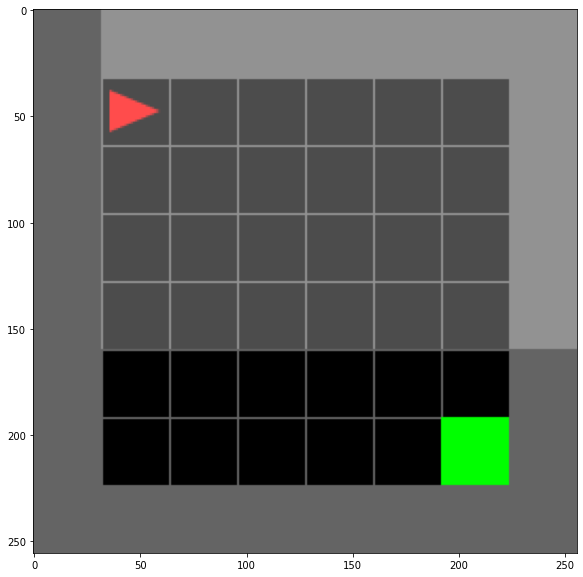

In [7]:
obvs = env.reset()
show_state(env)

In [53]:
state, reward = env._answer("grey wall is north")
state
reward

too many objects


0

In [18]:
state

array([1, 0])

In [78]:
# We have:
env._answer("green door is closed")

# We want:
env.step_oracle("green door is closed")

# answer - (0,0) (0,1) (1, 1)
# reward -  -1

no such object


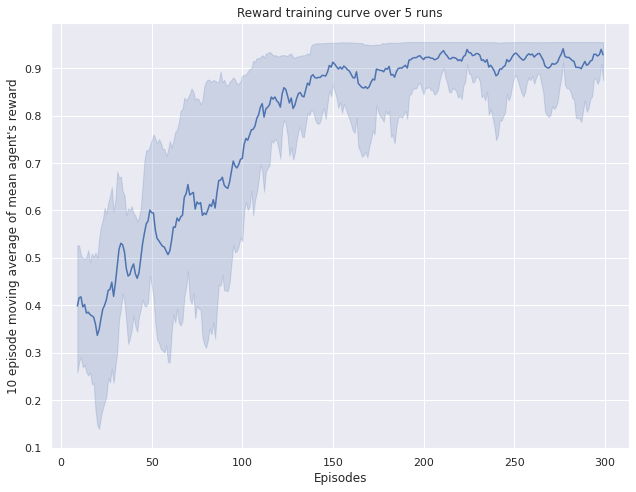

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111)

window = 10
avg = pd.DataFrame(np.array(runs_reward)).T.rolling(window).mean().T

df_reward_v2 = pd.DataFrame(avg).melt()
sns.lineplot(ax=ax, x='variable', y='value', data=df_reward_v2)
ax.set_title(f"Reward training curve over {runs} runs")
ax.set_ylabel(f"{window} episode moving average of mean agent\'s reward")
ax.set_xlabel("Episodes")
plt.tight_layout()
plt.show()